In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.graphics.api import abline_plot
from sklearn.svm import SVC
import time
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv('data/03_eda_loans50k.csv', index_col=[0])
top_features = pd.read_csv('data/top_features.csv', index_col=[0])

In [3]:
df.head()

,amount,term,length,home,income,verified,status,reason,state,debtIncRat,...,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
loanID,,,,,,,,,,,,,,,,,,,,,
188861,8000.0,36 months,3 years,RENT,49966.0,Verified,Default,Credit Card,Quartile_3,30.05,...,15.0,48054.0,8100.0,8.0,4369.0,43.0,95.7,48054.0,1000.0,52529.0
517703,11000.0,36 months,10+ years,MORTGAGE,50000.0,Not Verified,Current,Debt Consolidation,Quartile_3,8.74,...,15.0,265838.0,33400.0,4.0,22153.0,19756.0,37.5,11844.0,31600.0,0.0
268587,35000.0,36 months,10+ years,RENT,360000.0,Verified,Current,Debt Consolidation,Quartile_3,14.50,...,14.0,850150.0,83000.0,2.0,121450.0,7686.0,83.2,173260.0,83000.0,100000.0
579902,20000.0,60 months,2 years,MORTGAGE,60000.0,Verified,Current,Debt Consolidation,Quartile_3,14.14,...,48.0,20671.0,14200.0,8.0,1723.0,11061.0,1.2,20671.0,11200.0,32764.0
617630,12000.0,60 months,10+ years,MORTGAGE,64000.0,Verified,Current,Debt Consolidation,Quartile_3,5.14,...,22.0,128034.0,14600.0,3.0,18291.0,5904.0,58.4,8475.0,14200.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49184 entries, 188861 to 500393
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       49184 non-null  float64
 1   term         49184 non-null  object 
 2   length       49184 non-null  object 
 3   home         49184 non-null  object 
 4   income       49184 non-null  float64
 5   verified     49184 non-null  object 
 6   status       49184 non-null  object 
 7   reason       49184 non-null  object 
 8   state        49184 non-null  object 
 9   debtIncRat   49184 non-null  float64
 10  delinq2yr    49184 non-null  float64
 11  inq6mth      49184 non-null  float64
 12  openAcc      49184 non-null  float64
 13  pubRec       49184 non-null  float64
 14  revolRatio   49184 non-null  float64
 15  totalAcc     49184 non-null  float64
 16  totalBal     49184 non-null  float64
 17  totalRevLim  49184 non-null  float64
 18  accOpen24    49184 non-null  float64
 19

**Before encoding, I need to map the length feature to preserve the hierarchical order of the data.**

In [5]:
# Confirm unique values to be mapped.
print(df['length'].unique())

['3 years' '10+ years' '2 years' '< 1 year' '9 years' '5 years' '1 year'
 '4 years' '8 years' '7 years' '6 years' '0 years']


In [6]:
length_map = {"0 years": 0, "< 1 year": 1, "1 year": 2, "2 years": 3, "3 years": 4,\
              "4 years": 5, "5 years": 6, "6 years": 7, "7 years": 8,\
              "8 years": 9, "9 years": 10, "10+ years": 11}
df['length'] = df['length'].map(length_map).astype(int)

In [7]:
# Check new variables
df.length.unique()

array([ 4, 11,  3,  1, 10,  6,  2,  5,  9,  8,  7,  0])

**Split data into target variable and predictive features Then I used dummy encoding to transform categorical features to numeric.**

In [8]:
# Split and then get dummies
X = df.drop('status', axis=1)
y = df['status']
# Encode y
y = y.replace({'Current': 0, 'Default': 1})

In [9]:
# Create dummies and check new feautures
X = pd.get_dummies(X, drop_first=False)
X.columns

Index(['amount', 'length', 'income', 'debtIncRat', 'delinq2yr', 'inq6mth',
       'openAcc', 'pubRec', 'revolRatio', 'totalAcc', 'totalBal',
       'totalRevLim', 'accOpen24', 'avgBal', 'bcOpen', 'bcRatio',
       'totalRevBal', 'totalBcLim', 'totalIlLim', 'term_ 36 months',
       'term_ 60 months', 'home_MORTGAGE', 'home_OWN', 'home_RENT',
       'verified_Not Verified', 'verified_Verified', 'reason_Car',
       'reason_Credit Card', 'reason_Debt Consolidation',
       'reason_Home Improvement', 'reason_House', 'reason_Major Purchase',
       'reason_Medical', 'reason_Moving', 'reason_Other',
       'reason_Renewable Energy', 'reason_Small Business', 'reason_Vacation',
       'reason_Wedding', 'state_DC', 'state_Quartile_1', 'state_Quartile_2',
       'state_Quartile_3', 'state_Quartile_4'],
      dtype='object')

In [10]:
len(X.columns)

44

In [11]:
X.dtypes.value_counts()

uint8      25
float64    18
int64       1
dtype: int64

In [12]:
# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

In [13]:
# Confirm uint8 have been changes to int64
X.dtypes.value_counts()

int64      26
float64    18
dtype: int64

**Train / Test Split & Scale using StandardScaler.**

In [14]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# initialize a StandardScaler object and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply the scaling transformation to both the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**I checked to see if there was a similar amount of defaults in the training and test set. The ratio is close.**

In [15]:
# Find ratios of defaults in the training set
ratio_defaults_train = y_train.sum() / len(y_train)
# Find ratios of defaults in the test set
ratio_defaults_test = y_test.sum() / len(y_test)
print(f"The ratio of defaults in the training set is {ratio_defaults_train:.2%} and the ratio in the test set is \
{ratio_defaults_test:.2%}")

The ratio of defaults in the training set is 15.53% and the ratio in the test set is 14.95%


**Data is ready for modeling. I'm going to try 4 algorithms and pick the top one or two to move forward with: <br> Logistic Regression <br> Random Forest Classifier <br> Gradient Boosting Classifier <br> Support Vector Machines (SVM)**

In [16]:
start_time = time.time()

# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred)
lr_rec = recall_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
lr_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)
print("Total Time:", lr_total_time)

Accuracy: 0.6386093321134492
Precision: 0.2380593262946204
Recall: 0.6437797416723318
F1 score: 0.3475867131583777
ROC-AUC score: 0.6407399784144591
Total Time: 0.13387370109558105


In [17]:
start_time = time.time()

# Create a random forest classifier object
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on the training data (unscaled)
rfc.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = rfc.predict(X_test)

# Calculate the metrics
rfc_acc = accuracy_score(y_test, y_pred)
rfc_prec = precision_score(y_test, y_pred)
rfc_rec = recall_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred)
rfc_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
rfc_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", rfc_acc)
print("Precision:", rfc_prec)
print("Recall:", rfc_rec)
print("F1 score:", rfc_f1)
print("ROC-AUC score:", rfc_roc_auc)
print('Total Time:', rfc_total_time)

Accuracy: 0.8505641964013418
Precision: 0.5555555555555556
Recall: 0.003399048266485384
F1 score: 0.006756756756756756
ROC-AUC score: 0.5014604612597069
Total Time: 8.189098119735718


In [18]:
start_time = time.time()

# Create a gradient boosting classifier object
gb = GradientBoostingClassifier(random_state=42)

# Train the model on the training data (unscaled)
gb.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = gb.predict(X_test)

# Calculate the metrics
gb_acc = accuracy_score(y_test, y_pred)
gb_prec = precision_score(y_test, y_pred)
gb_rec = recall_score(y_test, y_pred)
gb_f1 = f1_score(y_test, y_pred)
gb_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
gb_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", gb_acc)
print("Precision:", gb_prec)
print("Recall:", gb_rec)
print("F1 score:", gb_f1)
print("ROC-AUC score:", gb_roc_auc)
print('Total Time:', gb_total_time)

Accuracy: 0.8508691674290942
Precision: 0.5555555555555556
Recall: 0.013596193065941536
F1 score: 0.026542800265428
ROC-AUC score: 0.5058418450388279
Total Time: 13.339850902557373


In [19]:
start_time = time.time()

# Initialize the SVC with default hyperparameters
svc = SVC(class_weight='balanced', random_state=42)

# Train the SVC on the training set (scaled)
svc.fit(X_train_scaled, y_train)

# Make predictions on the test set (scaled)
y_pred = svc.predict(X_test_scaled)

# Calculate the metrics
svc_acc = accuracy_score(y_test, y_pred)
svc_prec = precision_score(y_test, y_pred)
svc_rec = recall_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred)
svc_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
svc_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", svc_acc)
print("Precision:", svc_prec)
print("Recall:", svc_rec)
print("F1 score:", svc_f1)
print("ROC-AUC score:", svc_roc_auc)
print('Total Time:', svc_total_time)

Accuracy: 0.6402358442614619
Precision: 0.23608984175599795
Recall: 0.628823929299796
F1 score: 0.34329189088884765
ROC-AUC score: 0.6355331695267806
Total Time: 208.87556099891663


In [20]:
# create a dictionary of scores for each model
scores_dict = {
    'Model': ['LR','RFC', 'GB', 'SVC'],
    'Accuracy': [lr_acc, rfc_acc, gb_acc, svc_acc],
    'Precision': [lr_prec, rfc_prec, gb_prec, svc_prec],
    'Recall': [lr_rec, rfc_rec, gb_rec, svc_rec],
    'F1 Score': [lr_f1, rfc_f1, gb_f1, svc_f1],
    'ROC-AUC Score': [lr_roc_auc, rfc_roc_auc, gb_roc_auc, svc_roc_auc,],
    'Total Time': [lr_total_time, rfc_total_time, gb_total_time, svc_total_time]
}

# create the DataFrame
scores_df = pd.DataFrame(scores_dict)
scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score,Total Time
0,LR,0.638609,0.238059,0.643780,0.347587,0.640740,0.133874
1,RFC,0.850564,0.555556,0.003399,0.006757,0.501460,8.189098
2,GB,0.850869,0.555556,0.013596,0.026543,0.505842,13.339851
3,SVC,0.640236,0.236090,0.628824,0.343292,0.635533,208.875561


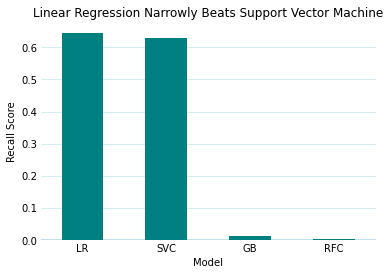

In [21]:
# sort the DataFrame by 'Recall' column
scores_df_sorted = scores_df.sort_values(by='Recall', ascending=False)

# plot a horizontal bar chart
ax = scores_df_sorted.plot(x='Model', y='Recall', kind='bar', legend=False, color='teal')

# Add title and labels for x-axis & y-axis
ax.set_title('Linear Regression Narrowly Beats Support Vector Machine')
ax.set_xlabel('Model')
ax.set_ylabel('Recall Score')

plt.xticks(rotation=0)

# Add horizontal lines behind the bars.
for i in range(0, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/13_Recall Scores by Model', dpi=300, bbox_inches='tight')

plt.show()

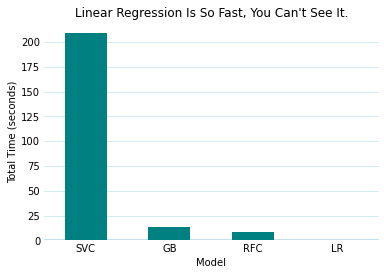

In [22]:
# sort the DataFrame by 'Total Time' column
times_df_sorted = scores_df.sort_values(by='Total Time', ascending=False)

# plot a horizontal bar chart
ax = times_df_sorted.plot(x='Model', y='Total Time', kind='bar', legend=False, color='teal')

# Add title and labels for x-axis & y-axis
ax.set_title("Linear Regression Is So Fast, You Can't See It.")
ax.set_xlabel('Model')
ax.set_ylabel('Total Time (seconds)')

plt.xticks(rotation=0)

# Add horizontal lines behind the bars.
for i in range(0, 201, 25):
    plt.axhline(y=i, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/14_Total Time by Model', dpi=300, bbox_inches='tight')

plt.show()

**Because we care most about detecting true loan defaults, we will move forward with logistic regression as it has the highest recall score. SVC is a close second but it takes much longer to run the model and is still not performing as well. I wanted to see if I could get better results from my model by addressing the class imbalance with different sampling techniques so I tried synthetic oversampling, random oversampling and random undersampling. I then tested the results again using Logistic Regression.**

In [23]:
# create oversampled training set using synthetic data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# create oversampled training set
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

# create undersampled training set
rus = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [24]:
# Use synthetic oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
sm_lr_acc = accuracy_score(y_test, y_pred)
sm_lr_prec = precision_score(y_test, y_pred)
sm_lr_rec = recall_score(y_test, y_pred)
sm_lr_f1 = f1_score(y_test, y_pred)
sm_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", sm_lr_acc)
print("Precision:", sm_lr_prec)
print("Recall:", sm_lr_rec)
print("F1 score:", sm_lr_f1)
print("ROC-AUC score:", sm_lr_roc_auc)

Accuracy: 0.6386093321134492
Precision: 0.23963018490754623
Recall: 0.6519374575118967
F1 score: 0.35044765211035994
ROC-AUC score: 0.6441016477136341


In [25]:
# Use random oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_ros, y_train_ros)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
ros_lr_acc = accuracy_score(y_test, y_pred)
ros_lr_prec = precision_score(y_test, y_pred)
ros_lr_rec = recall_score(y_test, y_pred)
ros_lr_f1 = f1_score(y_test, y_pred)
ros_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", ros_lr_acc)
print("Precision:", ros_lr_prec)
print("Recall:", ros_lr_rec)
print("F1 score:", ros_lr_f1)
print("ROC-AUC score:", ros_lr_roc_auc)

Accuracy: 0.6389143031412016
Precision: 0.23771111671288128
Recall: 0.6410605030591434
F1 score: 0.34681868333946303
ROC-AUC score: 0.6397987191365524


In [26]:
# Use random udersampling

# Train the model on the training data (scaled data)
lr.fit(X_train_rus, y_train_rus)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
rus_lr_acc = accuracy_score(y_test, y_pred)
rus_lr_prec = precision_score(y_test, y_pred)
rus_lr_rec = recall_score(y_test, y_pred)
rus_lr_f1 = f1_score(y_test, y_pred)
rus_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", rus_lr_acc)
print("Precision:", rus_lr_prec)
print("Recall:", rus_lr_rec)
print("F1 score:", rus_lr_f1)
print("ROC-AUC score:", rus_lr_roc_auc)

Accuracy: 0.6407441293077157
Precision: 0.23786531130876748
Recall: 0.6363018354860639
F1 score: 0.34628190899001116
ROC-AUC score: 0.6389135283096109


In [27]:
# create a dictionary of scores for each model
lr_scores_dict = {
    'Model': ['LR','LR: Smote', 'LR: ROS', 'LR: RUS'],
    'Accuracy': [lr_acc, sm_lr_acc, ros_lr_acc, rus_lr_acc],
    'Precision': [lr_prec, sm_lr_prec, ros_lr_prec, rus_lr_prec],
    'Recall': [lr_rec, sm_lr_rec, ros_lr_rec, rus_lr_rec],
    'F1 Score': [lr_f1, sm_lr_f1, ros_lr_f1, rus_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, sm_lr_roc_auc, ros_lr_roc_auc, rus_lr_roc_auc]
}

# create the DataFrame
lr_scores_df = pd.DataFrame(lr_scores_dict)
lr_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR,0.638609,0.238059,0.643780,0.347587,0.640740
1,LR: Smote,0.638609,0.239630,0.651937,0.350448,0.644102
2,LR: ROS,0.638914,0.237711,0.641061,0.346819,0.639799
3,LR: RUS,0.640744,0.237865,0.636302,0.346282,0.638914


**I moved forward with SMOTE synthetic oversampling to tune my hyperparameters. It had the highest scores in all metrics except accuracy which I am less concerned about.**

In [28]:
start_time = time.time()

# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Define the hyperparameters to search over
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['saga', 'lbfgs', 'newton-cg', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

# Create a RandomizedSearchCV object
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=params, n_iter=10, cv=5, random_state=42, scoring='recall')

# Train the model on the training data
lr_random.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters
best_params = lr_random.best_params_
print(best_params)

# Train the model with the best hyperparameters on the training data
lr = LogisticRegression(class_weight='balanced', random_state=42, **best_params)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
tuned_lr_acc = accuracy_score(y_test, y_pred)
tuned_lr_prec = precision_score(y_test, y_pred)
tuned_lr_rec = recall_score(y_test, y_pred)
tuned_lr_f1 = f1_score(y_test, y_pred)
tuned_lr_roc_auc = roc_auc_score(y_test, y_pred)
tuned_lr_conf_matrix = confusion_matrix(y_test, y_pred)

end_time = time.time()
tuned_lr_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", tuned_lr_acc)
print("Precision:", tuned_lr_prec)
print("Recall:", tuned_lr_rec)
print("F1 score:", tuned_lr_f1)
print("ROC-AUC score:", tuned_lr_roc_auc)
print('Total Time:', tuned_lr_total_time)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 0.1}
Accuracy: 0.6388126461319508
Precision: 0.239880059970015
Recall: 0.6526172671651937
F1 score: 0.35081308240453135
ROC-AUC score: 0.6445013182586666
Total Time: 64.8058979511261


In [29]:
# create a dictionary of scores for each model
lr_tuned_scores_dict = {
    'Model': ['LR: Smote', 'LR: Smote - Tuned'],
    'Accuracy': [lr_acc, tuned_lr_acc],
    'Precision': [lr_prec, tuned_lr_prec],
    'Recall': [lr_rec, tuned_lr_rec],
    'F1 Score': [lr_f1, tuned_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, tuned_lr_roc_auc]}

# create the DataFrame
lr_tuned_scores_df = pd.DataFrame(lr_tuned_scores_dict)
lr_tuned_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR: Smote,0.638609,0.238059,0.643780,0.347587,0.640740
1,LR: Smote - Tuned,0.638813,0.239880,0.652617,0.350813,0.644501


**Plot the feature importance & the coefficient matrix.**

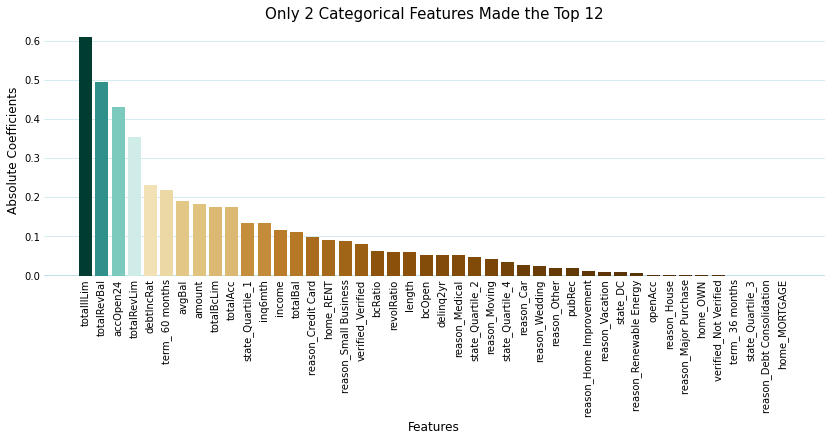

In [40]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# Plot the feature importance with a color gradient
plt.figure(figsize=(14, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))
plt.xticks(rotation=90)

# Add title and labels for x-axis & y-axis
plt.xlabel('Features', size=12)
plt.ylabel('Absolute Coefficients', size=12)
plt.title('Only 2 Categorical Features Made the Top 12', size=15)

# Add horizontal lines behind the bars.
for i in range(0, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Save the figure as a PNG image
plt.savefig('Images/15_Feature Importance', dpi=300, bbox_inches='tight')

plt.show()

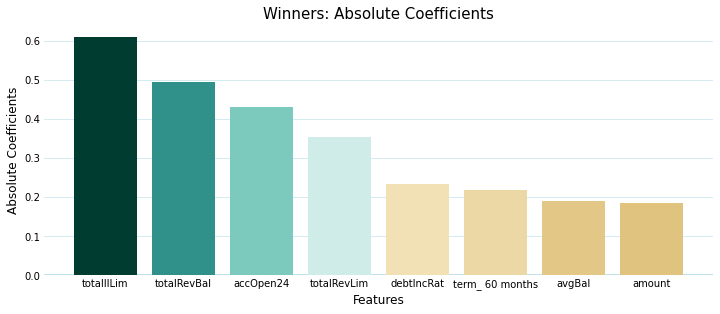

In [31]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

# Labels for Xticks
x_labels = ['Total of Credit Limits \nfor Installment Accounts', \
                                         'Total Credit Balance \n(Except Mortgages)',\
                                         'Total Accounts Opened \nin the Past 24 Months',\
                                         'Sum of Credit Limits \nfrom All Credit Lines',\
                                         'Reason for Loan: \nDebt Consolodation']

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx][:8]
sorted_features = [features[i] for i in sorted_idx][:8]

# Plot the feature importance with a color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))

# Add title and labels for x-axis, y-axis & x-ticks
plt.title('Winners: Absolute Coefficients', size=15)
plt.xlabel('Features', size=12)
plt.ylabel('Absolute Coefficients', size=12)
plt.xticks(range(len(sorted_features)))

# Add horizontal lines behind the bars.
for i in range(1, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Save the figure as a PNG image
plt.savefig('Images/16_Top Coefficients', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
# top_features['Absolute Coefficients'] = sorted_features

In [33]:
# top_features

In [34]:
# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_coefs = coefs[sorted_idx]

# Create a DataFrame with the sorted features and coefficients
df_feature_importance = pd.DataFrame({'Feature': sorted_features, 'Coefficient': sorted_coefs})

# Print the DataFrame with the feature importance
df_feature_importance

,Feature,Coefficient
0,totalIlLim,0.609695
1,totalRevBal,0.494318
2,accOpen24,0.430033
3,totalRevLim,0.354182
4,debtIncRat,0.232478
5,term_ 60 months,0.218206
6,avgBal,0.190920
7,amount,0.183874
8,totalBcLim,0.173890
9,totalAcc,0.173871


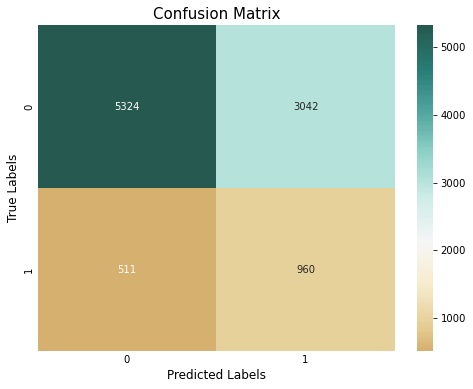

In [41]:
# Define the base colormap
cmap_base = plt.cm.get_cmap('BrBG')

# Shift the colormap
shifted_cmap = ListedColormap(cmap_base(np.linspace(0.25, 1, 256)))

# Plot the confusion matrix using the shifted colormap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(tuned_lr_conf_matrix, annot=True, fmt='d', cmap=shifted_cmap, alpha=0.85)

# Add title and labels for x-axis & y-axis
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Labels', size=12)
plt.ylabel('True Labels', size=12)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# # Set the x-tick labels and y-tick labels
# ax.set_xticklabels(['Current', 'Default'], ha='center')
# ax.set_yticklabels(['Current', 'Default'], va='center', ha='right')

# Save the figure as a PNG image
plt.savefig('Images/17_Confusion Matrix', dpi=300, bbox_inches='tight')

plt.show()